# semopyを使ってパス解析として同時方程式を解いてみる

In [1]:
cd /workdir

/workdir


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import semopy

In [3]:
df = pd.read_stata("mccrary/originallevittfiles/crime.dta")
df

,name,city,statenam,state,censdist,year,sworn,civil,elecyear,governor,...,a10_14,a15_19,a20_24,a25_29,citybla,cityfemh,sta_educ,sta_welf,price,termlim
0,albuquerque,1,,31,85.0,69,328.0,127.0,1,0.0,...,0.120523,0.101880,0.087395,0.068698,NaN,NaN,NaN,NaN,NaN,0.0
1,albuquerque,1,nm,31,85.0,70,370.0,124.0,0,1.0,...,0.115725,0.101487,0.089538,0.072414,2.20,12.30,829.896973,157.216507,0.388,0.0
2,albuquerque,1,nm,31,85.0,71,377.0,197.0,0,0.0,...,0.111225,0.101117,0.091548,0.075900,2.23,12.19,834.567871,172.839508,0.405,1.0
3,albuquerque,1,nm,31,85.0,72,389.0,155.0,0,0.0,...,0.106995,0.100770,0.093436,0.079176,2.26,12.08,846.889954,179.425827,0.418,1.0
4,albuquerque,1,nm,31,85.0,73,447.0,137.0,1,0.0,...,0.103013,0.100443,0.095215,0.082261,2.29,11.97,828.828857,173.423431,0.444,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411,corpuschri,85,tx,43,74.0,88,350.0,128.0,0,0.0,...,0.086284,0.084445,0.073147,0.084052,4.86,13.12,832.453735,151.898453,1.183,0.0
1412,corpuschri,85,tx,43,74.0,89,355.0,139.0,1,0.0,...,0.085946,0.082849,0.070815,0.083415,4.83,13.46,847.580627,159.677414,1.240,0.0
1413,corpuschri,85,tx,43,74.0,90,370.0,146.0,0,1.0,...,0.085612,0.081273,0.068513,0.082786,4.80,13.80,873.756775,193.573074,1.307,0.0
1414,corpuschri,85,tx,43,NaN,91,380.0,144.0,1,0.0,...,0.085283,0.079718,0.066240,0.082166,4.77,14.14,847.232483,234.686340,NaN,0.0


In [4]:
df.columns

Index(['name', 'city', 'statenam', 'state', 'censdist', 'year', 'sworn',
       'civil', 'elecyear', 'governor', 'murder', 'rape', 'robbery', 'assault',
       'burglary', 'larceny', 'auto', 'rincpc', 'econgrow', 'unemp', 'citypop',
       'term2', 'term3', 'term4', 'a0_5', 'a5_9', 'a10_14', 'a15_19', 'a20_24',
       'a25_29', 'citybla', 'cityfemh', 'sta_educ', 'sta_welf', 'price',
       'termlim'],
      dtype='object')

## 前処理

In [5]:
# firststa.doを参考に10万人あたりの数にする
for col in ["sworn", "civil", "murder", "rape", "assault", "robbery", "sta_educ", "sta_welf"]:
    df[col] = df[col] / df["citypop"] * 100_000
    
# 都市ごとに年について差分をとって変化率にするために、都市名と年でソートする
df = df.sort_values(["name", "year"])

# Δln (変化率) にする
violent_crimes = ["murder", "rape", "robbery", "assault"]
property_crimes = ["burglary", "larceny", "auto"]
for col in ["sworn", *violent_crimes, *property_crimes, "sta_educ", "sta_welf"]:
    df[f"d_{col}"] = np.log(df[col]).diff()
# 割合系のやつも差分をとって変化率にする
df["a15_24"] = df["a15_19"] + df["a20_24"]
percent_covariates = ["unemp", "a15_24", "citybla", "cityfemh"]
for col in percent_covariates:
    df[f"d_{col}"] = df[col].diff()

# citysize
df["citysize"] = 0
citypop = df["citypop"]
df.loc[citypop<250000, "citysize"] = 1
df.loc[(citypop<500000) & (citypop>=250000), "citysize"] = 2
df.loc[(citypop<1000000) & (citypop>=500000), "citysize"] = 3
df.loc[(citypop>=1000000), "citysize"] = 5

# 前年の警察官の変化率（1年遅れで効果がでる可能性を考慮）
df["d_sworn_2"] = df["d_sworn"].shift(1)

TODO: 縦持ちにする

In [6]:
# # 犯罪を縦持ちにする
# violent_crimes = ["murder", "rape", "robbery", "assault"]
# property_crimes = ["burglary", "larceny", "auto"]

# # test = df.query("name == 'chicago'")[['name', 'city', 'statenam', 'state', 'censdist', 'year', 'sworn', 'murder', 'rape', 'robbery', 'assault', 'burglary', 'larceny', 'auto']]
# # test.melt(id_vars=["name", "year"], value_vars=violent_crimes, var_name="crime_name", value_name="crime").merge(test, on=["name", "year"])

# df_viol = df.melt(id_vars=["name", "year"], value_vars=violent_crimes, var_name="crime_name", value_name="crime").merge(df, on=["name", "year"]).drop(violent_crimes, axis=1)
# df_prop = df.melt(id_vars=["name", "year"], value_vars=property_crimes, var_name="crime_name", value_name="crime").merge(df, on=["name", "year"]).drop(property_crimes, axis=1)

In [7]:
# 犯罪をまとめるならこれ
# generate violent=murder+rape+robbery+assa
# generate property=burgl+larc+auto

In [8]:
# entity demeaned
for col in ["d_sworn", "d_murder"]:
    for name, d in df.groupby("name"):
        df.loc[d.index, f"{col}_dem"] = d[col] - d[col].mean()

## Modeling

まずシンプルにやりたい

$$
\Delta \ln C_{ijt} = 
  \beta_{1j} \Delta \ln P_{it}
+ \boldsymbol{X}_{it} \eta_j
+ \gamma_{tj}
+ \lambda_i
+ \varepsilon_{ijt}
$$

- $C_{ijt}$: 都市$i$、年$t$の犯罪$j$の数（$\Delta \ln$は前年からの変化率の意味）

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,d_sworn_dem,~,elecyear,0.038,0.035,1.104,0.269
1,d_sworn_dem,~,governor,0.056,0.044,1.257,0.209
2,d_sworn_dem,~,d_murder_dem,-1.588,1.025,-1.550,0.121
3,d_murder_dem,~,d_sworn_dem,22.320,9.956,2.242,0.025
4,d_murder_dem,~,d_sta_educ,-6.252,2.776,-2.252,0.024
5,d_murder_dem,~,d_sta_welf,-0.170,0.268,-0.633,0.527
6,d_murder_dem,~,d_unemp,0.178,2.414,0.074,0.941
7,d_murder_dem,~,d_a15_24,-0.210,4.302,-0.049,0.961
8,d_murder_dem,~,d_citybla,0.112,0.103,1.084,0.279
9,d_murder_dem,~,d_cityfemh,0.177,0.180,0.983,0.325


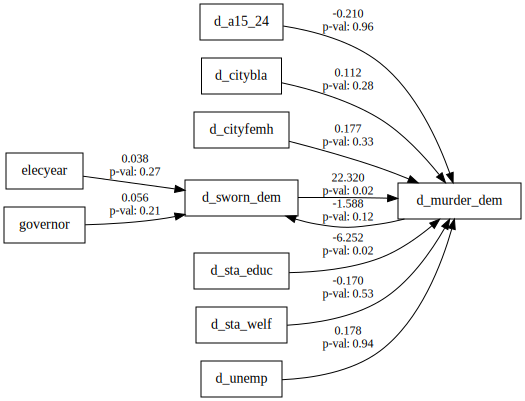

In [9]:
model = semopy.Model("""
d_sworn_dem ~ elecyear + governor + d_murder_dem
d_murder_dem ~ d_sworn_dem + d_sta_educ + d_sta_welf + d_unemp + d_a15_24 + d_citybla + d_cityfemh
""")
model.fit(df)
display(model.inspect().round(3))

g = semopy.semplot(model, "/tmp/img.png", plot_covs=True)
g.attr(rankdir="LR")
with g.subgraph() as s:
    s.attr(rank = "max")
    s.node("d_murder_dem")
g

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,d_sworn_dem,~,elecyear,-0.000,0.006,-0.057,0.955
1,d_murder_dem,~,elecyear,-0.076,0.016,-4.840,0.000
2,d_sworn_dem,~~,d_sworn_dem,0.011,0.000,26.608,0.000
3,d_murder_dem,~~,d_murder_dem,0.073,0.003,26.608,0.000


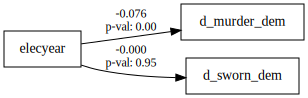

In [10]:
model = semopy.Model("""
d_sworn_dem ~ elecyear 
d_murder_dem ~ elecyear
""")
model.fit(df)
display(model.inspect().round(3))

g = semopy.semplot(model, "/tmp/img.png", plot_covs=True)
g.attr(rankdir="LR")
with g.subgraph() as s:
    s.attr(rank = "max")
    s.node("d_murder_dem")
g